# NICE 2024
# Training Spiking Neural Networks in snnTorch
### Written by Jason Eshraghian and Bernhard Vogginger

What you will learn:
* Learn how spiking neurons are implemented as a recurrent network
* Download event-based data and train a spiking neural network with it
* Export it to the neuromorphic intermediate representation

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

## 1. Imports

In [1]:
!pip install snntorch --quiet
!pip install tonic --quiet

In [2]:
# imports
import snntorch as snn

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 2. Handling Event-based Data with Tonic

## 2.1 PokerDVS Dataset

The dataset used in this tutorial is POKERDVS by T. Serrano-Gotarredona and B. Linares-Barranco:

```
Serrano-Gotarredona, Teresa, and Bernabé Linares-Barranco. "Poker-DVS and MNIST-DVS. Their history, how they were made, and other details." Frontiers in neuroscience 9 (2015): 481.
```

It is comprised of four classes, each being a suite of a playing card deck: clubs, spades, hearts, and diamonds. The data consists of 131 poker pip symbols, and was collected by flipping poker cards in front of a DVS128 camera.

[(    0,  7, 22, 1) (   16, 19, 13, 0) (   18, 24, 23, 1) ...
 (14239, 21, 16, 1) (14246, 24, 14, 1) (14247, 14, 14, 1)]


/tmp/ipykernel_12252/1180474003.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events)


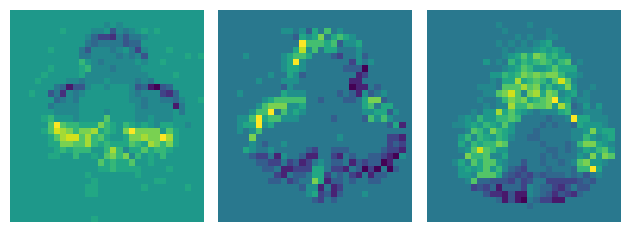

In [3]:
import tonic

poker_train = tonic.datasets.POKERDVS(save_to='./data', train=True)
poker_test = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, target = poker_train[0]
print(events)
tonic.utils.plot_event_grid(events)

In [4]:
import tonic.transforms as transforms
from tonic import DiskCachedDataset

# time_window
frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000),
                                            tonic.transforms.ToFrame(
                                            sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                            time_window=1000)
                                            ])

batch_size = 8
cached_trainset = DiskCachedDataset(poker_train, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(poker_test, transform=frame_transform, cache_path='./cache/pokerdvs/test')

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

data, labels = next(iter(train_loader))
print(data.size())
print(labels)

torch.Size([25, 8, 2, 35, 35])
tensor([1, 3, 3, 3, 2, 1, 2, 0])


## 3. Define the SNN

In [5]:
num_inputs = 35*35*2
num_hidden = 128
num_outputs = 4

In [6]:
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In the following code-block, note how the decay rate `beta` has two alternative definitions:
* `beta1` is set to a global decay rate for all neurons in the first spiking layer.
* `beta2` is randomly initialized to a vector of 10 different numbers. Each spiking neuron in the output layer (which not-so-coincidentally has 10 neurons) therefore has a unique, and random, decay rate.

In [7]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        alpha1 = 0.5
        beta1 = 0.9 # global decay rate for all leaky neurons in layer 1
        beta2 = torch.rand((num_outputs), dtype = torch.float) # independent decay rate for each leaky neuron in layer 2: [0, 1)
        threshold2 = torch.ones_like(beta2) # threshold parameter must have the same shape as beta for NIR
        alpha2 = torch.ones_like(beta2)*0.9
        
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Synaptic(alpha=alpha1, beta=beta1) # not a learnable decay rate
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Synaptic(alpha=alpha2, beta=beta2, threshold=threshold2, learn_beta=True) # learnable decay rate

    def forward(self, x):
        syn1, mem1 = self.lif1.init_synaptic() # reset/init hidden states at t=0
        syn2, mem2 = self.lif2.init_synaptic() # reset/init hidden states at t=0

        spk2_rec = [] # record output spikes
        mem2_rec = [] # record output hidden states

        for step in range(x.size(0)): # loop over time
            cur1 = self.fc1(x[step].flatten(1))
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2) # record spikes
            mem2_rec.append(mem2) # record membrane

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the POKERDVS dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

A 'biophysical' interpretation is that `fc1` and `fc2` generate current injections that are fed into a set of $128$ and $10$ spiking neurons in `lif1` and `lif2`, respectively.

> Note: the number of spiking neurons is automatically inferred by the dimensionality of the dimensions of the current injection value.

# 4. Training the **SNN**

## 4.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [8]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()


## 4.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [9]:
loss = nn.CrossEntropyLoss()

## 4.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 4.4 One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [11]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

Pass the input data to the network.

In [12]:
spk_rec, mem_rec = net(data)
print(mem_rec.size())

torch.Size([28, 8, 4])


The recording of the membrane potential is taken across:
* 29 time steps
* 8 samples of data
* 4 output neurons

We wish to calculate the loss at every time step, and sum these up together:


$$\mathcal{L}_{Total-CE} = \sum_t\mathcal{L}_{CE}[t]$$

In [13]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(mem_rec.size(0)):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 42058.758


The loss is quite large, because it is summed over 29-ish time steps. The accuracy is also bad (it should be roughly around 25%) as the network is untrained:

In [14]:
measure_accuracy(net, train_loader)

0.1875

A single weight update is applied to the network as follows:

In [15]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [16]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data)

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(mem_rec.size(0)):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
measure_accuracy(net, train_loader)

Training loss: 53.313


0.2916666567325592

After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6 in the snnTorch docs](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 4.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [17]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(mem_rec.size(0)):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(test_mem.size(0)):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            # if counter % 50 == 0:
            print(f"Iteration: {counter} \t Accuracy: {measure_accuracy(net, test_loader)}")
            counter += 1
            iter_counter +=1

Iteration: 0 	 Accuracy: 0.30000001192092896
Iteration: 1 	 Accuracy: 0.25
Iteration: 2 	 Accuracy: 0.4000000059604645
Iteration: 3 	 Accuracy: 0.30000001192092896
Iteration: 4 	 Accuracy: 0.5
Iteration: 5 	 Accuracy: 0.550000011920929
Iteration: 6 	 Accuracy: 0.75
Iteration: 7 	 Accuracy: 0.800000011920929
Iteration: 8 	 Accuracy: 0.75
Iteration: 9 	 Accuracy: 0.75
Iteration: 10 	 Accuracy: 0.800000011920929
Iteration: 11 	 Accuracy: 0.75
Iteration: 12 	 Accuracy: 0.75
Iteration: 13 	 Accuracy: 0.75
Iteration: 14 	 Accuracy: 0.75
Iteration: 15 	 Accuracy: 0.75
Iteration: 16 	 Accuracy: 0.75
Iteration: 17 	 Accuracy: 0.75
Iteration: 18 	 Accuracy: 0.75
Iteration: 19 	 Accuracy: 0.75
Iteration: 20 	 Accuracy: 0.75
Iteration: 21 	 Accuracy: 0.75
Iteration: 22 	 Accuracy: 0.75
Iteration: 23 	 Accuracy: 0.75
Iteration: 24 	 Accuracy: 0.75
Iteration: 25 	 Accuracy: 0.75
Iteration: 26 	 Accuracy: 0.75
Iteration: 27 	 Accuracy: 0.75
Iteration: 28 	 Accuracy: 0.75
Iteration: 29 	 Accuracy: 0.7

If this was your first time training an SNN, then congratulations. I'm proud of you and I always believed in you.

In [18]:
measure_accuracy(net, test_loader)

0.75

# 5. Export to NIR

In [19]:
import nir

In [20]:
nir_model = snn.export_to_nir(net.cpu(), data.cpu())
nir.write("nir_model.nir", nir_model)

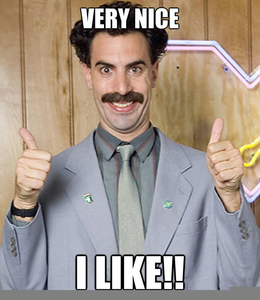

In [21]:
#@title Run this block for a good time
import requests
from IPython.display import Image, display

def display_image_from_url(url):
    response = requests.get(url, stream=True)
    display(Image(response.content))

url = "http://www.clker.com/cliparts/7/8/a/0/1498553633398980412very-nice-borat.med.png"
display_image_from_url(url)

# Conclusion

That covers how to train a spiking neural network and convert it into the neuromorphic intermediate representation. There are a lot of ways to alter this, e.g., by using different neuron models, surrogate gradients, learnable beta and threshold values, or modifying the fully-connected layers by replacing them with convolutions or whatever else you fancy.

# 6. Run the model with Norse

## 6.1 Import NIR model to Norse

In [22]:
!pip install norse --quiet

In [23]:
import norse.torch as norse

In [24]:
nir_model = nir.read("nir_model.nir")

In [25]:
norse_model = norse.from_nir(nir_model, dt=0.0001)

In [26]:
norse_model.to(device)

GraphExecutor(
  (fc1): Linear(in_features=2450, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (input): Identity()
  (lif1): CubaLIF(
    (synapse): LIBoxCell(p=LIBoxParameters(tau_mem_inv=tensor(5000.), v_leak=tensor(0.)), dt=0.0001)
    (lif): LIFBoxCell(p=LIFBoxParameters(tau_mem_inv=tensor(1000.0002), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.), reset_method=<function reset_value at 0x7269ddc35ab0>), dt=0.0001)
  )
  (lif2): CubaLIF(
    (synapse): LIBoxCell(p=LIBoxParameters(tau_mem_inv=tensor([1000.0003, 1000.0003, 1000.0003, 1000.0003]), v_leak=tensor([0., 0., 0., 0.])), dt=0.0001)
    (lif): LIFBoxCell(p=LIFBoxParameters(tau_mem_inv=tensor([6959.4067, 2405.2061, 2971.3215, 9211.4092]), v_leak=tensor([0., 0., 0., 0.]), v_th=tensor([1., 1., 1., 1.]), v_reset=tensor(0.), method='super', alpha=tensor(100.), reset_method=<function reset_value at 0x7269ddc35ab0>), dt=0.0001)
  )
  (output): Id

**TODO: add some information about the `nirtorch.GraphExecutor`** 

## 6.2. Run the model with a single batch of data

The graph executor can run a single forward step. Let's add the recurrence...

In [27]:
def apply(data):
    """
    apply an input data batch to the norse model
    """
    state = None
    hid_rec = []
    out = []
    
    for i, t in enumerate(data):
        z, state = norse_model(t.flatten(1), state)
        out.append(z)
        hid_rec.append(state)
    spk_out = torch.stack(out)
    # hid_rec = torch.stack(hid_rec)
    return spk_out, hid_rec

Apply to a batch of data

In [28]:
data, targets = next(iter(test_loader))

spk, hid = apply(data)

# count the number of spikes for each neuron and assess the winner
predictions = spk.sum(axis=0).argmax(axis=-1)
print(f"Predicted classes: {predictions}")
print(f"Actual classes:    {targets}")

Predicted classes: tensor([1, 2, 1, 0, 0, 0, 2, 1])
Actual classes:    tensor([1, 2, 3, 3, 0, 0, 2, 1])


### 6.3 Measure accuracy for test dataset

In [29]:
def measure_accuracy2(model, dataloader):
  with torch.no_grad():
    # model.eval()  # not needed!
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()

In [30]:
measure_accuracy2(apply, test_loader)

0.75